In [1]:
%config Completer.use_jedi = False
import sys
import warnings
warnings.filterwarnings('ignore')

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

MEMORY = 40*1024

gpus = tf.config.list_physical_devices('GPU')
try:
    tf.config.set_logical_device_configuration(gpus[0],
                                              [tf.config.LogicalDeviceConfiguration(memory_limit=MEMORY)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
except RuntimeError as e:        
    # Memory growth must be set before GPUs have been initialized
    print(e) 
    
import pathlib
import pickle
from pathlib import Path
sys.path.append(f"{Path.home()}/morpho_repo")
sys.path.append(f"{Path.home()}/morpho_repo/turing_codebase")
from turing.utils import *
from turing.tf_utils import *
import turing.pinns as tu
from turing.loss_functions import *

2023-02-10 12:01:09.996627: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-10 12:01:10.247810: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-10 12:01:10.950248: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /end/home/rh2310/lib:/end/soft/Linux_2.6_64/lib::/end/home/rh2310/.conda/envs/tensorflo

1 Physical GPUs, 1 Logical GPUs


In [2]:
from local_utils import *

In [3]:
sim_name = "Koch_Meinhardt_5"
x_slice=slice(0,100,1)#slice(30,65,1)#slice(50,65,1)#
y_slice=slice(0,100,1)#slice(50,85,1)#slice(70,85,1)#
pattern = load(sim_name, x_slice, y_slice,
               data_time_start=-300,
               data_time_len=60,
               data_time_step=5)

In [4]:
#@tf.function
def grads(pinn, ts):
    
    with tf.GradientTape(persistent=True) as tape:
        H = pinn.make_inputs(ts)
        tape.watch(H)      
        
        with tf.GradientTape(persistent=True) as tape2:             
            tape2.watch(H)            
            outputs = pinn.net(H)            
        
            u = tf.squeeze(outputs[:, :, :, 0])
            v = tf.squeeze(outputs[:, :, :, 1])
            
        grad_u = tape2.gradient(u, H)
        u_x = grad_u[:, :, :, 0]
        u_y = grad_u[:, :, :, 1]
        u_t = grad_u[:, :, :, 2]

        grad_v = tape2.gradient(v, H)
        v_x = grad_v[:, :, :, 0]
        v_y = grad_v[:, :, :, 1]
        v_t = grad_v[:, :, :, 2]
            
    grad_u_x = tape.gradient(u_x, H)
    u_xx = grad_u_x[:, :, :, 0]
    u_yx = grad_u_x[:, :, :, 1]
    #u_tx = grad_u_x[:, :, :, 2]
    grad_u_y = tape.gradient(u_y, H)
    u_xy = grad_u_y[:, :, :, 0]
    u_yy = grad_u_y[:, :, :, 1]
    #u_ty = grad_u_y[:, :, :, 2]
    grad_v_x = tape.gradient(v_x, H)
    v_xx = grad_v_x[:, :, :, 0]
    v_yx = grad_v_x[:, :, :, 1]
    #v_tx = grad_v_x[:, :, :, 2]
    grad_v_y = tape.gradient(v_y, H)
    v_xy = grad_v_y[:, :, :, 0]
    v_yy = grad_v_y[:, :, :, 1]
    #v_ty = grad_v_y[:, :, :, 2]
    return (tf.squeeze(u),
            tf.squeeze(u_xx), tf.squeeze(u_yy), tf.squeeze(u_xy), tf.squeeze(u_yx), tf.squeeze(u_t),
            tf.squeeze(v),
            tf.squeeze(v_xx), tf.squeeze(v_yy), tf.squeeze(v_xy), tf.squeeze(v_yx), tf.squeeze(v_t))


In [5]:
def gen_series():    
    for i,t in enumerate(pattern.t_star):
        yield t, pattern.c[..., i]
        
ds = tf.data.Dataset.from_generator(gen_series,
                                    output_types=(tf.float32, tf.float32), 
                                    output_shapes=((), pattern.c.shape[:-1]))

In [6]:
pattern.t_star.shape

(12,)

In [7]:

x_range = np.linspace(0, 1, pattern.simulation.n[0])*pattern.simulation.L[0]
y_range = np.linspace(0, 1, pattern.simulation.n[0])*pattern.simulation.L[1]
x_range = x_range[x_slice]
y_range = y_range[y_slice]

optimizer=keras.optimizers.Adam(learning_rate=5e-3)
pinn = tu.NN_Field(x_range, y_range, 
                layers=[3, 512, 512, 512, 2], 
                dim_2d=(pattern.block_x, pattern.block_x), 
                dtype=tf.float32)
norm_l2 = L2()

init_per = 2.0
D_u = tf.constant(pattern.params["D_u"], pinn.dtype, name="D_u")#tf.Variable(pattern.params["D_u"]*init_per, pinn.dtype)
D_v = tf.constant(pattern.params["D_v"], pinn.dtype, name="D_v")#tf.Variable(pattern.params["D_v"]*init_per, pinn.dtype)
def clip_by_value_zero_lb(z):
    return tf.clip_by_value(z, 0, 1e10,)

sigma_u = tf.Variable(pattern.params["sigma_u"]*init_per,
                      pinn.dtype,
                      name="sigma_u",
                      constraint=clip_by_value_zero_lb)


sigma_v = tf.Variable(pattern.params["sigma_v"]*init_per,
                      pinn.dtype,
                      name="sigma_v",
                      constraint=clip_by_value_zero_lb)

mu_u = tf.Variable(pattern.params["mu_u"]*init_per,
                   pinn.dtype,
                   name="mu_u",
                   constraint=clip_by_value_zero_lb)

rho_u = tf.Variable(pattern.params["rho_u"]*init_per,
                    pinn.dtype,
                    name="rho_u",
                    constraint=clip_by_value_zero_lb)

rho_v = tf.Variable(pattern.params["rho_v"]*init_per,
                    pinn.dtype,
                    name="rho_v",
                    constraint=clip_by_value_zero_lb)

kappa_u = tf.Variable(pattern.params["kappa_u"]*init_per,
                      pinn.dtype,
                      name="kappa_u",
                      constraint=clip_by_value_zero_lb)


params_tf = (sigma_u, sigma_v, mu_u, rho_u, rho_v, kappa_u,)

@tf.function
def train_step_inverse(elements):
    with tf.GradientTape(persistent=True) as tape: 
        H = pinn.make_inputs(elements[0])
        tape.watch(H)
        trainables = pinn.trainable_variables
        
        with tf.GradientTape(persistent=True) as tape2:             
            tape2.watch(H)
            
            outputs = pinn.net(H)            
            u = tf.squeeze(outputs[:, :, :, 0])
            v = tf.squeeze(outputs[:, :, :, 1])
            
            grad_u = tape2.gradient(u, H)
            u_x = grad_u[:, :, :, 0]
            u_y = grad_u[:, :, :, 1]
            u_t = grad_u[:, :, :, 2]
            
            grad_v = tape2.gradient(v, H)
            v_x = grad_v[:, :, :, 0]
            v_y = grad_v[:, :, :, 1]
            v_t = grad_v[:, :, :, 2]
                    
        grad_u_x = tape.gradient(u_x, H)
        u_xx = grad_u_x[:, :, :, 0]
        u_yx = grad_u_x[:, :, :, 1]
        #u_tx = grad_u_x[:, :, :, 2]
        grad_u_y = tape.gradient(u_y, H)
        u_xy = grad_u_y[:, :, :, 0]
        u_yy = grad_u_y[:, :, :, 1]
        #u_ty = grad_u_y[:, :, :, 2]
        grad_v_x = tape.gradient(v_x, H)
        v_xx = grad_v_x[:, :, :, 0]
        v_yx = grad_v_x[:, :, :, 1]
        #v_tx = grad_v_x[:, :, :, 2]
        grad_v_y = tape.gradient(v_y, H)
        v_xy = grad_v_y[:, :, :, 0]
        v_yy = grad_v_y[:, :, :, 1]
        #v_ty = grad_v_y[:, :, :, 2]
                             
        f = u * u * v / (1.0 + kappa_u * u * u)
        f_u = D_u * (u_xx + u_yy) + rho_u * f - mu_u * u + sigma_u - u_t
        f_v = D_v * (v_xx + v_yy) - rho_v * f + sigma_v - v_t
        l2_res_u = tf.reduce_sum(f_u**2)
        l2_res_v = tf.reduce_sum(f_v**2)
        
        u_diff = u - elements[1][:, 0, :, :]
        v_diff = v - elements[1][:, 1, :, :]
        l2_u_obs = tf.reduce_sum(u_diff**2)
        l2_v_obs = tf.reduce_sum(v_diff**2)

        u_xyyx_diff = u_xy - u_yx
        v_xyyx_diff = v_xy - v_yx
        l2_res_u_xyyx = tf.reduce_sum(u_xyyx_diff**2)
        l2_res_v_xyyx = tf.reduce_sum(v_xyyx_diff**2)

                
        l2 = l2_u_obs + l2_v_obs + l2_res_u + l2_res_v + l2_res_u_xyyx + l2_res_v_xyyx
       
    grads = tape.gradient(l2, trainables + params_tf)
    optimizer.apply_gradients(zip(grads, trainables + params_tf))
    return (l2_u_obs, l2_v_obs, l2_res_u, l2_res_v, l2_res_u_xyyx, l2_res_v_xyyx)


In [8]:
batch_size = 4
def print_callback(printer, losses, epoch):
    printer(f"at epoch {epoch:d}\n"
            f" total loss: {np.sum(losses)}"
            f" u: {losses[0]}, v: {losses[1]},\n"
            f" Res u: {losses[2]}, Res v: {losses[3]} \n"
            f" Res u xyyx: {losses[4]}, Res v xyyx: {losses[5]}")
    printer(#f"D_u: {D_u.numpy()}, D_v: {D_v.numpy()} \n"
            f"rho_u: {rho_u.numpy()}, rho_v: {rho_v.numpy()} \n"
            f"sigma_u: {sigma_u.numpy()}, sigma_v: {sigma_v.numpy()} \n"
            f"kappa_u: {kappa_u.numpy()}, mu_u: {mu_u.numpy()} \n")
            #f" Res u xyyx: {losses[4]}, Res v xyyx: {losses[5]}")
losses = tu.train(epochs=10000+1,
                  batch_size=batch_size,
                  dataset = ds ,
                  train_step = train_step_inverse,
                  train_step_returns_num = 6,
                  print_interval=100,
                  loss_sample_interval = 1,
                  stop_threshold=1e-8,
                  print_callback = print_callback,
                  epoch_callback=None)



Start of epoch 0


2023-02-10 12:01:54.563949: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-02-10 12:01:54.733285: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f8e48004b40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-02-10 12:01:54.733353: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA A40, Compute Capability 8.6
2023-02-10 12:01:54.740262: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-02-10 12:01:55.899436: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


at epoch 0
 total loss: 204638423041.22705 u: 1724097.3806152344, v: 3140313.1875,
 Res u: 3235475350.0651855, Res v: 201398083280.59375 
 Res u xyyx: 1.963106608597206e-15, Res v xyyx: 2.3249911036078614e-15
rho_u: 0.7930859923362732, rho_v: 6.0005269050598145 
sigma_u: 0.1868162900209427, sigma_v: 1.9931894540786743 
kappa_u: 0.003194056684151292, mu_u: 2.0119152069091797 

Time taken: 23.91s

Start of epoch 100
at epoch 100
 total loss: 66270.50715923312 u: 79.3928861618042, v: 58036.26513671875,
 Res u: 460.94020080566406, Res v: 7693.908935546875 
 Res u xyyx: 9.756465167015671e-12, Res v xyyx: 2.1752297445915003e-11
rho_u: 0.7525069117546082, rho_v: 5.959967136383057 
sigma_u: 0.1941685974597931, sigma_v: 1.9883652925491333 
kappa_u: 0.042331937700510025, mu_u: 2.0523056983947754 

Time taken: 154.97s

Start of epoch 200
at epoch 200
 total loss: 16112.412526249993 u: 21.5312739610672, v: 13192.688446044922,
 Res u: 158.53594589233398, Res v: 2739.6568603515625 
 Res u xyyx: 3.87

at epoch 2200
 total loss: 4687542.212890625 u: 106177.11328125, v: 4214569.875,
 Res u: 280593.1484375, Res v: 86202.076171875 
 Res u xyyx: 0.0, Res v xyyx: 0.0
rho_u: 0.5738269090652466, rho_v: 5.762044429779053 
sigma_u: 0.0, sigma_v: 1.3826568126678467 
kappa_u: 0.1194634959101677, mu_u: 2.086578845977783 

Time taken: 154.46s

Start of epoch 2300
at epoch 2300
 total loss: 4487280.2421875 u: 86879.521484375, v: 4114653.25,
 Res u: 214308.0625, Res v: 71439.408203125 
 Res u xyyx: 0.0, Res v xyyx: 0.0
rho_u: 0.5737375020980835, rho_v: 5.762044429779053 
sigma_u: 0.0, sigma_v: 1.333425521850586 
kappa_u: 0.1194634959101677, mu_u: 2.0734453201293945 

Time taken: 154.47s

Start of epoch 2400
at epoch 2400
 total loss: 4288678.248046875 u: 68468.744140625, v: 3999944.75,
 Res u: 153057.12890625, Res v: 67207.625 
 Res u xyyx: 0.0, Res v xyyx: 0.0
rho_u: 0.5736480951309204, rho_v: 5.762044429779053 
sigma_u: 0.0, sigma_v: 1.2797497510910034 
kappa_u: 0.1194634959101677, mu_u: 2.062135


Start of epoch 4500
at epoch 4500
 total loss: 585.8953584766132 u: 521.4207763671875, v: 60.269755363464355,
 Res u: 0.002911571238655597, Res v: 4.2019151747226715 
 Res u xyyx: 0.0, Res v xyyx: 0.0
rho_u: 0.573463499546051, rho_v: 5.762044429779053 
sigma_u: 0.24299411475658417, sigma_v: 0.9806250929832458 
kappa_u: 0.1194634959101677, mu_u: 2.037273645401001 

Time taken: 154.72s

Start of epoch 4600
at epoch 4600
 total loss: 571.6269841677858 u: 506.08795166015625, v: 60.369272232055664,
 Res u: 0.0028892047121189535, Res v: 5.166871070861816 
 Res u xyyx: 0.0, Res v xyyx: 0.0
rho_u: 0.573463499546051, rho_v: 5.762044429779053 
sigma_u: 0.2437596172094345, sigma_v: 0.9912164807319641 
kappa_u: 0.1194634959101677, mu_u: 2.037273645401001 

Time taken: 154.90s

Start of epoch 4700
at epoch 4700
 total loss: 555.5654940741224 u: 491.7261962890625, v: 60.37221717834473,
 Res u: 0.0003874437970807776, Res v: 3.466693162918091 
 Res u xyyx: 0.0, Res v xyyx: 0.0
rho_u: 0.57346349954605


Start of epoch 6700
at epoch 6700
 total loss: 128.717694284991 u: 44.10164260864258, v: 60.315168380737305,
 Res u: 0.03801447399018798, Res v: 24.26286882162094 
 Res u xyyx: 0.0, Res v xyyx: 0.0
rho_u: 0.5734836459159851, rho_v: 5.762001037597656 
sigma_u: 0.27629420161247253, sigma_v: 1.6134883165359497 
kappa_u: 0.1194634959101677, mu_u: 2.0370607376098633 

Time taken: 154.97s

Start of epoch 6800
at epoch 6800
 total loss: 580.4783415645361 u: 46.96725559234619, v: 60.96542739868164,
 Res u: 0.6268353313207626, Res v: 471.9188232421875 
 Res u xyyx: 0.0, Res v xyyx: 0.0
rho_u: 0.573492705821991, rho_v: 5.761974811553955 
sigma_u: 0.27650612592697144, sigma_v: 1.627780556678772 
kappa_u: 0.1194634959101677, mu_u: 2.0369880199432373 

Time taken: 154.92s

Start of epoch 6900
at epoch 6900
 total loss: 102.35706546285655 u: 35.99656391143799, v: 60.3414249420166,
 Res u: 0.009731614380143583, Res v: 6.00934499502182 
 Res u xyyx: 0.0, Res v xyyx: 0.0
rho_u: 0.5735039114952087, rho


Start of epoch 8900
at epoch 8900
 total loss: 3913.2585805654526 u: 62.39351940155029, v: 61.722042083740234,
 Res u: 5.971754431724548, Res v: 3783.1712646484375 
 Res u xyyx: 0.0, Res v xyyx: 0.0
rho_u: 0.5767077207565308, rho_v: 5.753525733947754 
sigma_u: 0.26676681637763977, sigma_v: 1.5583261251449585 
kappa_u: 0.1194768026471138, mu_u: 2.0116913318634033 

Time taken: 154.48s

Start of epoch 9000
at epoch 9000
 total loss: 155.0727183688432 u: 60.98990440368652, v: 61.35726070404053,
 Res u: 0.04509996064007282, Res v: 32.680453300476074 
 Res u xyyx: 0.0, Res v xyyx: 0.0
rho_u: 0.5772944092750549, rho_v: 5.751977920532227 
sigma_u: 0.2667381167411804, sigma_v: 1.553133487701416 
kappa_u: 0.11947986483573914, mu_u: 2.0070250034332275 

Time taken: 154.52s

Start of epoch 9100
at epoch 9100
 total loss: 137.11240991577506 u: 62.76536178588867, v: 61.490793228149414,
 Res u: 0.019458021968603134, Res v: 12.836796879768372 
 Res u xyyx: 0.0, Res v xyyx: 0.0
rho_u: 0.5779666900634

In [17]:
losses2 = tu.train(epochs=30000+1,
                  batch_size=batch_size,
                  dataset = ds ,
                  train_step = train_step_inverse,
                  train_step_returns_num = 6,
                  print_interval=1000,
                  loss_sample_interval = 1,
                  stop_threshold=1e-8,
                  print_callback = print_callback,
                  epoch_callback=None)


Start of epoch 0
at epoch 0
 total loss: 187.24988476652652 u: 47.977416038513184, v: 62.226844787597656,
 Res u: 0.07023827452212572, Res v: 76.97538566589355 
 Res u xyyx: 0.0, Res v xyyx: 0.0
rho_u: 0.5860288739204407, rho_v: 5.720843315124512 
sigma_u: 0.252188116312027, sigma_v: 1.5944933891296387 
kappa_u: 0.11953694373369217, mu_u: 1.9423424005508423 

Time taken: 1.62s

Start of epoch 1000
at epoch 1000
 total loss: 90.82267164470977 u: 14.315254211425781, v: 64.08902740478516,
 Res u: 0.004663698695367202, Res v: 12.413726329803467 
 Res u xyyx: 0.0, Res v xyyx: 0.0
rho_u: 0.5990195274353027, rho_v: 5.637312412261963 
sigma_u: 0.23477371037006378, sigma_v: 1.696772813796997 
kappa_u: 0.11969184130430222, mu_u: 1.8672401905059814 

Time taken: 1570.67s

Start of epoch 2000
at epoch 2000
 total loss: 71.79828849119622 u: 2.360292434692383, v: 67.89998531341553,
 Res u: 0.006341871447148151, Res v: 1.531668871641159 
 Res u xyyx: 0.0, Res v xyyx: 0.0
rho_u: 0.6133070588111877, r


Start of epoch 21000
at epoch 21000
 total loss: 72.32308423821814 u: 0.16812819615006447, v: 70.71055603027344,
 Res u: 0.00042806961573660374, Res v: 1.443971942178905 
 Res u xyyx: 0.0, Res v xyyx: 0.0
rho_u: 0.44165846705436707, rho_v: 4.5245232582092285 
sigma_u: 0.2770184874534607, sigma_v: 1.4198113679885864 
kappa_u: 1.1524194478988647, mu_u: 1.7813990116119385 

Time taken: 1544.51s

Start of epoch 22000
at epoch 22000
 total loss: 68.28967046492107 u: 0.1699749007821083, v: 67.85098648071289,
 Res u: 0.0033699082414386794, Res v: 0.2653391751846357 
 Res u xyyx: 0.0, Res v xyyx: 0.0
rho_u: 0.4457536041736603, rho_v: 4.490579128265381 
sigma_u: 0.27510735392570496, sigma_v: 1.402816653251648 
kappa_u: 1.2260710000991821, mu_u: 1.7763094902038574 

Time taken: 1545.07s

Start of epoch 23000
at epoch 23000
 total loss: 70.38380324178252 u: 0.1661381945014, v: 68.81474494934082,
 Res u: 0.0009623774221836356, Res v: 1.4019577205181122 
 Res u xyyx: 0.0, Res v xyyx: 0.0
rho_u: 0.

In [ ]:
'rho_u': 0.4,  'rho_v': 3.0,
'sigma_u': 0.1, 'sigma_v': 1.0,
'kappa_u': 0.0, 'mu_u': 1.0,

In [9]:
pinn.save(".", "saved_models/pinn_2D_Koch_Meinhardt_5")

In [19]:
pattern.params

{'D_u': 0.02,
 'D_v': 1.0,
 'kappa_u': 0.0,
 'rho_u': 0.4,
 'mu_u': 1.0,
 'sigma_u': 0.1,
 'rho_v': 3.0,
 'sigma_v': 1.0}

In [20]:
def Euclidian_L(vec1, vec2):
    def L(v):
        return np.sqrt(np.sum(v**2))
    v2 = vec2.copy()
    v2[v2==0] = 1
    return L((vec1-vec2)/v2)

u_vec_ac = np.array([pattern.params["rho_u"], pattern.params["mu_u"],
                     pattern.params["sigma_u"], pattern.params["kappa_u"]])

u_vec    = np.array([rho_u.numpy(), mu_u.numpy(), sigma_u.numpy(), kappa_u.numpy()])

v_vec_ac = np.array([pattern.params["rho_v"], 
                     pattern.params["sigma_v"], pattern.params["kappa_u"]])

v_vec    = np.array([rho_v.numpy(), sigma_v.numpy(), kappa_u.numpy()])

print(f"U params. estimates: {Euclidian_L(u_vec, u_vec_ac)}")
print(f"V params. estimates: {Euclidian_L(v_vec, v_vec_ac)}")

U params. estimates: 2.497565522206662
V params. estimates: 1.7160801346504753


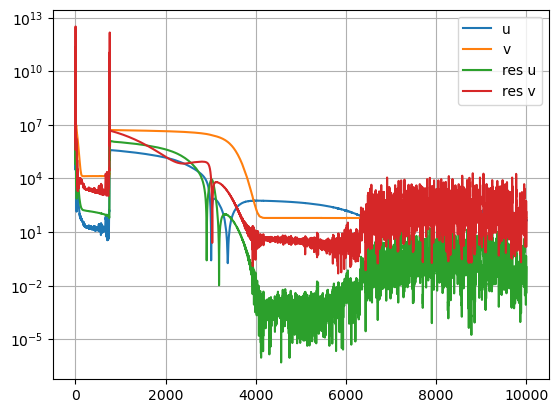

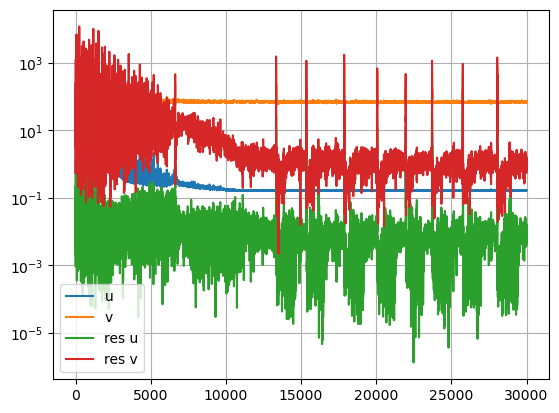

In [22]:
plt.plot(losses[:, 0], label='u')
plt.plot(losses[:, 1], label='v')
plt.plot(losses[:, 2], label='res u')
plt.plot(losses[:, 3], label='res v')
plt.yscale('log')
plt.grid(); plt.legend(); plt.show()

plt.plot(losses2[:, 0], label='u')
plt.plot(losses2[:, 1], label='v')
plt.plot(losses2[:, 2], label='res u')
plt.plot(losses2[:, 3], label='res v')
plt.yscale('log')
plt.grid(); plt.legend(); plt.show()

In [30]:
(u, u_xx, u_yy, u_xy, u_yx, u_t, 
 v, v_xx, v_yy, v_xy, v_yx, v_t) = grads(pinn, pattern.t_star[0:1].astype(np.float32))

In [31]:
def RMSE(arr1, arr2):
    #return np.sqrt(np.mean(((arr1-arr2)/np.max(arr2))**2))
    #return np.sqrt(np.mean(((arr1-arr2)/(arr2+1e-20))**2))
    return np.sqrt(np.mean(((arr1-arr2))**2))
                          
print("u: ", RMSE(u, pattern.c[0,:, : , -1]))
print("v: ", RMSE(v, pattern.c[1,:, : , -1]))
print("u_xx: ", RMSE(u_xx, pattern.c_xx[0,:, : , -1]))
print("v_xx: ", RMSE(v_xx, pattern.c_xx[1,:, : , -1]))
print("u_yy: ", RMSE(u_yy, pattern.c_yy[0,:, : , -1]))
print("v_yy: ", RMSE(v_yy, pattern.c_yy[1,:, : , -1]))
print("u_t: ", RMSE(u_t, pattern.c_t[0,:, : , -1]))
print("v_t: ", RMSE(v_t, pattern.c_t[1,:, : , -1]))

u:  0.0009968127
v:  0.018202635
u_xx:  0.0011601791
v_xx:  0.0037362566
u_yy:  0.0017918387
v_yy:  0.0057749595
u_t:  0.0002554275
v_t:  0.006784136


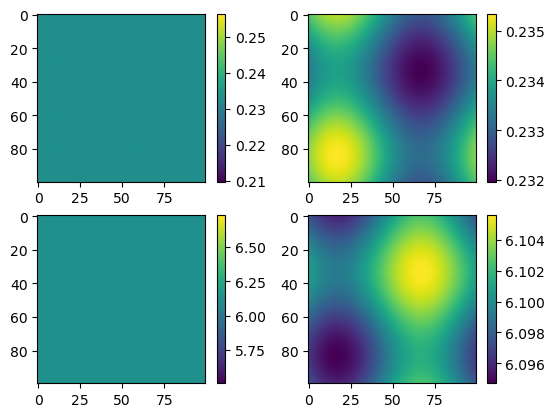

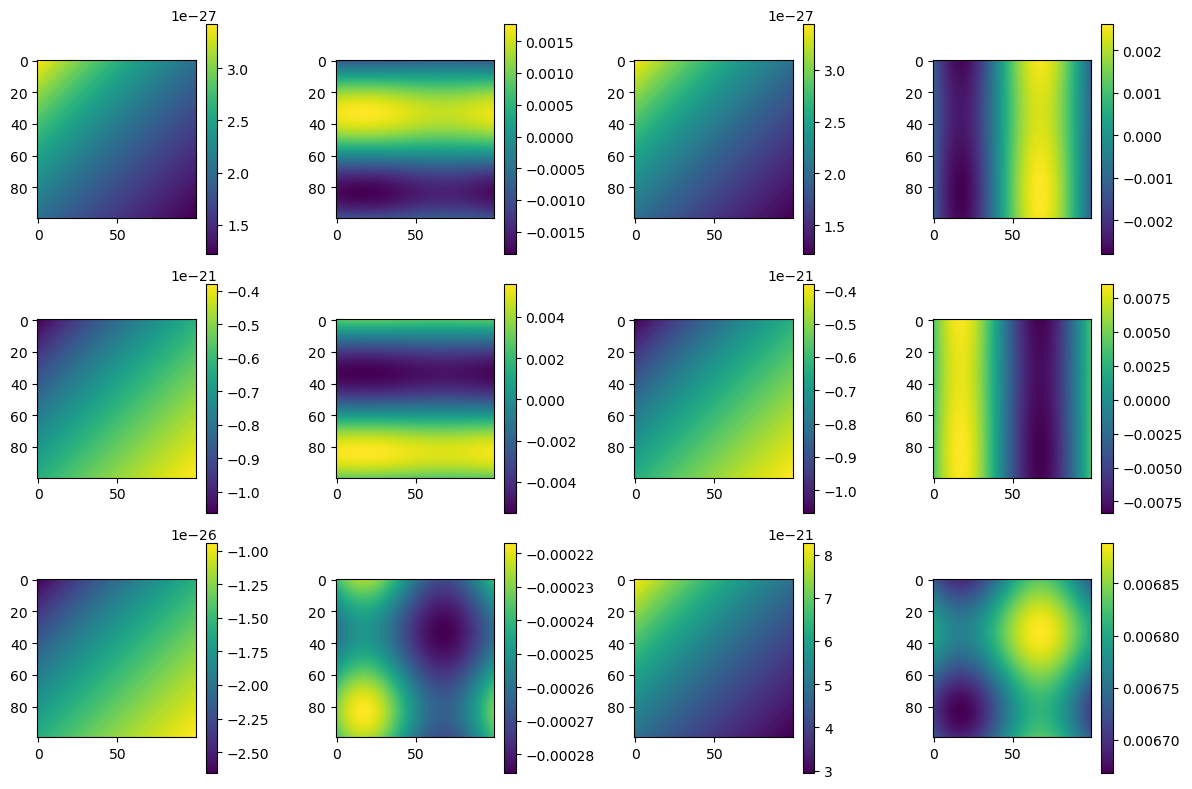

In [34]:
plt.subplot(221)
plt.imshow(u)
plt.colorbar()
plt.subplot(222)
plt.imshow(pattern.c[0,:,:,-1])
plt.colorbar()
plt.subplot(223)
plt.imshow(v)
plt.colorbar()
plt.subplot(224)
plt.imshow(pattern.c[1,:,:,-1])
plt.colorbar()
plt.show()

plt.figure(figsize=(12, 8))
plt.subplot(341)
plt.imshow(u_xx)
plt.colorbar()
plt.subplot(342)
plt.imshow(pattern.c_xx[0,:, : , -1])
plt.colorbar()
plt.subplot(343)
plt.imshow(u_yy)
plt.colorbar()
plt.subplot(344)
plt.imshow(pattern.c_yy[0,:, : , -1])
plt.colorbar()
plt.subplot(345)
plt.imshow(v_xx)
plt.colorbar()
plt.subplot(346)
plt.imshow(pattern.c_xx[1,:, : , -1])
plt.colorbar()
plt.subplot(347)
plt.imshow(v_yy)
plt.colorbar()
plt.subplot(3,4,8)
plt.imshow(pattern.c_yy[1,:, : , -1])
plt.colorbar()
plt.tight_layout()
plt.subplot(3,4,9)
plt.imshow(u_t)
plt.colorbar()
plt.subplot(3,4,10)
plt.imshow(pattern.c_t[0,:, : , -1])
plt.colorbar()
plt.subplot(3,4,11)
plt.imshow(v_t)
plt.colorbar()
plt.subplot(3,4,12)
plt.imshow(pattern.c_t[1,:, : , -1])
plt.colorbar()
plt.tight_layout()
plt.show()